In [20]:
import pandas as pd
import numpy as np
import multiprocessing as mp
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from gensim import corpora
from gensim.models import LdaModel
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import ParameterGrid
from gensim.models.coherencemodel import CoherenceModel
from sklearn.model_selection import train_test_split

In [40]:
df = pd.read_csv('X_clean.csv')

In [41]:
df.isna().sum()

Unnamed: 0                 0
title                      0
score                      0
tags                       0
creation_date              0
is_english                 0
cleaned_title            316
cleaned_title_strict    3479
lm                       316
dtype: int64

In [42]:
df = df.dropna()

In [43]:
def prepare_for_lda(df, target_column):
    df['cleaned_title_split'] = df[target_column].apply(lambda x: x.split() if isinstance(x, str) else x)
    dictionary = corpora.Dictionary(df['cleaned_title_split'])
    corpus = [dictionary.doc2bow(text) for text in df['cleaned_title_split']]
    print(dictionary)
    print(corpus)
    return dictionary, corpus

In [44]:
def get_topic_distribution(lda_model, corpus, nb_topic):
    doc_topic_distributions = [lda_model.get_document_topics(bow) for bow in corpus]
    topic_vectors = np.zeros((len(doc_topic_distributions), nb_topic))
    for i, doc in enumerate(doc_topic_distributions):
        for topic_id, prob in doc:
            topic_vectors[i, topic_id] = prob
    return topic_vectors

def print_TSNE(topic_vectors):
    tsne_model = TSNE(n_components=2, random_state=42)
    tsne_values = tsne_model.fit_transform(topic_vectors)
    plt.figure(figsize=(8, 8))
    plt.scatter(tsne_values[:, 0], tsne_values[:, 1], c=np.argmax(topic_vectors, axis=1), cmap='viridis')
    plt.colorbar(label='Topic')
    plt.title('2D visualization of LDA topic distribution using t-SNE')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()
    
def print_PCA(topic_vectors):
    pca_model = PCA(n_components=2)
    pca_values = pca_model.fit_transform(topic_vectors)
    plt.figure(figsize=(8, 8))
    plt.scatter(pca_values[:, 0], pca_values[:, 1], c=np.argmax(topic_vectors, axis=1), cmap='viridis')
    plt.colorbar(label='Topic')
    plt.title('2D visualization of LDA topic distribution using PCA')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()
    
def get_best_lda_model(dictionary, corpus, grid, texts):
    best_coherence = -1
    best_perplexity = 2**32
    best_params = None
    best_model = None

    for params in grid:
        lda_model = LdaModel(corpus=corpus,
                             id2word=dictionary,
                             num_topics=params['num_topics'],
                             passes=params['passes'])

        coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model_lda.get_coherence()
        perplexity = lda_model.log_perplexity(corpus)

        print(f"Topics: {params['num_topics']}, Passes: {params['passes']} -> Coherence: {coherence_score} Perplexity: {perplexity}")

        if coherence_score > best_coherence:
            best_coherence = coherence_score
            best_params = params
            best_model = lda_model
            best_perplexity = perplexity

    print(f"Best Coherence Score: {best_coherence}, have Perplexity: {best_perplexity} with Parameters: {best_params}")
    return best_model , int(best_params['num_topics'])



old outpout I took all words to clean not needed

In [45]:
train_data, test_data = train_test_split(df, test_size=0.2)
dictionary, corpus = prepare_for_lda(train_data, 'cleaned_title_strict')

Dictionary<2798 unique tokens: ['css', 'dataframe', 'pandas', 'keras', 'train']...>
[[(0, 1), (1, 1), (2, 1)], [(3, 1), (4, 1), (5, 1)], [(6, 1), (7, 1)], [(8, 1), (9, 1)], [(10, 1)], [(11, 1), (12, 1), (13, 1), (14, 1), (15, 1)], [(16, 1)], [(17, 1), (18, 1), (19, 1)], [(14, 1), (20, 1), (21, 1), (22, 1)], [(23, 1), (24, 1)], [(25, 1), (26, 1)], [(27, 1), (28, 1)], [(29, 1)], [(30, 1), (31, 1), (32, 1)], [(1, 1), (33, 1)], [(12, 1), (14, 1), (34, 1)], [(35, 1), (36, 2), (37, 1), (38, 1)], [(39, 1), (40, 1), (41, 1), (42, 1), (43, 1)], [(44, 1), (45, 1)], [(46, 1), (47, 1), (48, 1), (49, 1)], [(41, 1), (50, 1), (51, 1)], [(52, 1), (53, 1), (54, 1)], [(55, 1), (56, 1)], [(57, 1), (58, 1)], [(59, 1), (60, 1)], [(61, 1)], [(35, 1), (62, 1), (63, 1), (64, 1)], [(41, 1), (65, 1), (66, 1)], [(67, 1)], [(68, 1)], [(69, 1), (70, 1), (71, 1), (72, 1)], [(73, 1), (74, 1)], [(75, 1), (76, 1)], [(35, 1), (77, 1), (78, 1)], [(79, 1), (80, 1), (81, 1)], [(63, 1), (82, 1)], [(72, 1), (83, 1), (84, 1)

In [27]:
print(dictionary.token2id)

{'amp': 0, 'ghc': 1, 'stack': 2, 'versions': 3, 'ranges': 4, 'transform': 5, 'keyword': 6, 'struct': 7, 'unsafe': 8, 'view': 9, 'initialization': 10, 'referenceerror': 11, 'hints': 12, 'python': 13, 'str': 14, 'vs': 15, 'component': 16, 'prop': 17, 'react': 18, 'typescript': 19, 'coming': 20, 'reactjs': 21, 'safari': 22, 'dataframe': 23, 'pandas': 24, 'reacthookform': 25, 'register': 26, 'azure': 27, 'blob': 28, 'pipeline': 29, 'contract': 30, 'solidity': 31, 'structs': 32, 'compiler': 33, 'maven': 34, 'particular': 35, 'route': 36, 'adb': 37, 'jackson': 38, 'queries': 39, 'url': 40, 'vue': 41, 'f': 42, 'wpf': 43, 'c+': 44, 'hold': 45, 'polymorphism': 46, 'several': 47, 'wrapper': 48, 'pure': 49, 'recyclerview': 50, 'cloud': 51, 'google': 52, 'sql': 53, 'completablefuture': 54, 'completed': 55, 'controller': 56, 'dates': 57, 'future': 58, 'inserting': 59, 'pycharm': 60, 'stub': 61, 'flutter': 62, 'docker': 63, 'quotcannot': 64, 'wsl': 65, 'cut': 66, 'ffmpeg': 67, 'compose': 68, 'jetpac

essai avec lst de mot

In [46]:
param_grid = {
    'num_topics': [36, 38, 40, 42, 44],
    'passes': [10, 20, 30]
}

grid = ParameterGrid(param_grid)
best_lda, nb_topic = get_best_lda_model(dictionary, corpus, grid, train_data['cleaned_title_split'])
topic_vectors = get_topic_distribution(best_lda, corpus, nb_topic)

Topics: 36, Passes: 10 -> Coherence: 0.6736787960958396 Perplexity: -14.287491201536097
Topics: 36, Passes: 20 -> Coherence: 0.6678059097418121 Perplexity: -14.199909337899525
Topics: 36, Passes: 30 -> Coherence: 0.6735515235780148 Perplexity: -14.321353524330034
Topics: 38, Passes: 10 -> Coherence: 0.6769039224251242 Perplexity: -15.145669859165164
Topics: 38, Passes: 20 -> Coherence: 0.67590286847308 Perplexity: -15.305493900776831
Topics: 38, Passes: 30 -> Coherence: 0.6748323111730384 Perplexity: -15.191249094484721
Topics: 40, Passes: 10 -> Coherence: 0.6767858168591778 Perplexity: -16.08779014849318
Topics: 40, Passes: 20 -> Coherence: 0.6677251179483369 Perplexity: -16.1776106879754
Topics: 40, Passes: 30 -> Coherence: 0.6695017807613663 Perplexity: -16.19002599410869
Topics: 42, Passes: 10 -> Coherence: 0.6681544876402845 Perplexity: -16.824981229398762
Topics: 42, Passes: 20 -> Coherence: 0.6780956631277717 Perplexity: -16.857192380278455
Topics: 42, Passes: 30 -> Coherence: 0

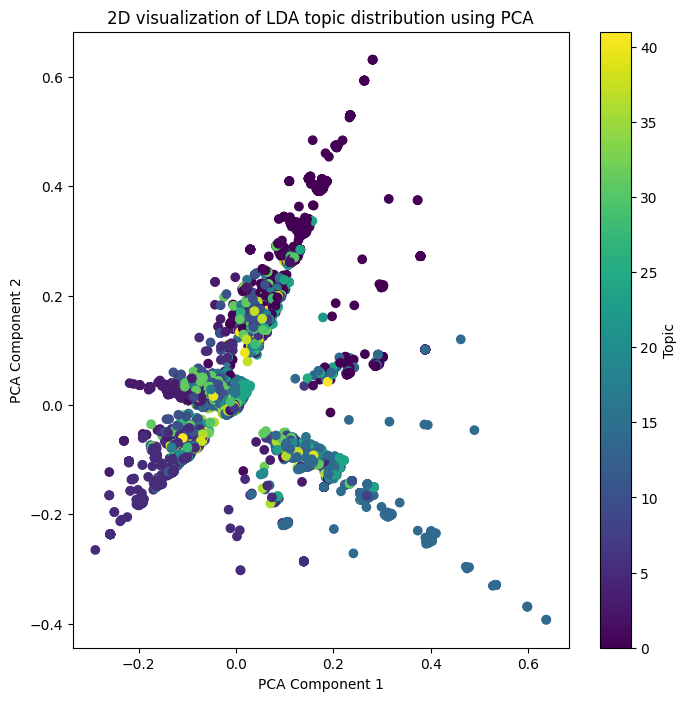

In [47]:
print_PCA(topic_vectors)

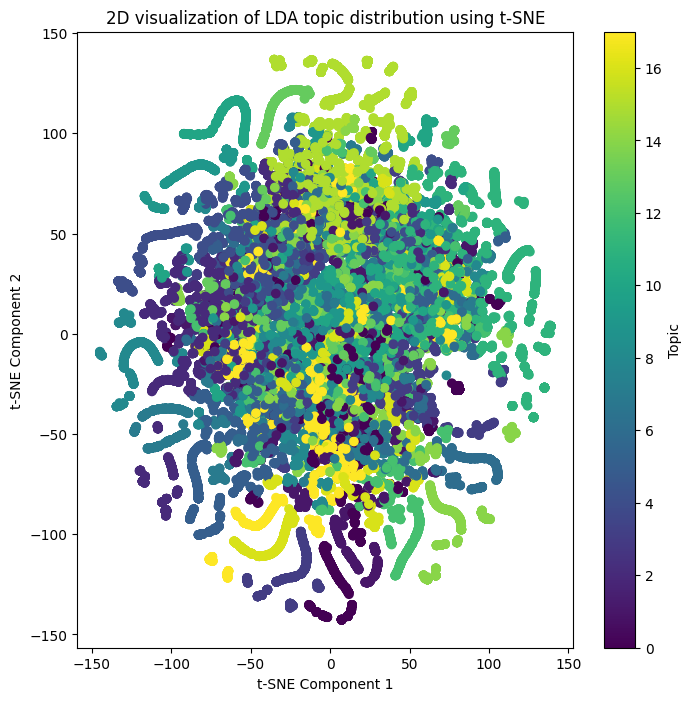

In [13]:
print_TSNE(topic_vectors)

In [48]:
best_lda.print_topics()

[(33,
  '0.093*"email" + 0.079*"theme" + 0.056*"excel" + 0.051*"dropdown" + 0.049*"rule" + 0.044*"ggplot" + 0.042*"behind" + 0.036*"verification" + 0.036*"skip" + 0.032*"algorithm"'),
 (9,
  '0.097*"blazor" + 0.086*"repository" + 0.049*"quot" + 0.041*"svg" + 0.040*"os" + 0.040*"shell" + 0.040*"launch" + 0.037*"reactive" + 0.036*"julia" + 0.032*"give"'),
 (21,
  '0.069*"runtime" + 0.065*"reactjs" + 0.064*"dockercompose" + 0.059*"vite" + 0.057*"rails" + 0.055*"apps" + 0.045*"https" + 0.042*"upgrading" + 0.040*"control" + 0.040*"editor"'),
 (14,
  '0.321*"angular" + 0.220*"typescript" + 0.112*"git" + 0.085*"jest" + 0.036*"plotly" + 0.018*"times" + 0.017*"integer" + 0.017*"warnings" + 0.015*"registry" + 0.011*"routing"'),
 (2,
  '0.228*"pandas" + 0.149*"dataframe" + 0.050*"plot" + 0.047*"production" + 0.045*"session" + 0.039*"identity" + 0.030*"logging" + 0.028*"inline" + 0.026*"init" + 0.026*"deploying"'),
 (30,
  '0.196*"nextjs" + 0.144*"vscode" + 0.103*"gradle" + 0.059*"vuejs" + 0.042*"